In [8]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from functions import *
import pandas as pd
import json
import os
os.chdir(r'./')

from gliner import GLiNER
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from tqdm import tqdm


In [9]:
with open('239_annotated_data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

from needed_functions import *

def replace_label(label_studio_data, old_label, new_label):
    """
    Remplace un label par un autre dans les données Label Studio.
    """
    for item in label_studio_data:
        if 'annotations' in item:
            for prediction in item['annotations']:
                for result in prediction['result']:
                    if result['type'] == 'labels':
                        labels = result['value']['labels']
                        for i, label in enumerate(labels):
                            if label == old_label:
                                labels[i] = new_label
    return label_studio_data

data = remove_text_duplicates(replace_label(filter_and_lowercase_entity_types(remove_text_duplicates(data), ["Autres"]), 'information temporelle', 'temporelle'))

print(f"Annotations uniques: {len(data)}")

Annotations uniques: 237


In [ ]:
from DynamicSegmentation import ThematicSegmenter
from SemanticQueryV1 import SemanticSearchEngine, SearchConfig

segmenter = ThematicSegmenter(window_size=2)
config = SearchConfig(threshold=0.1, batch_size=16, max_sequence_length=512)
search_engine = SemanticSearchEngine("paraphrase-multilingual-MiniLM-L12-v2", config)

from gliner import GLiNER

models = ["urchade/gliner_multi-v2.1", "numind/NuNerZero_span", "gliner_last_model", "nuner_last_model"]

device="cuda"
model = GLiNER.from_pretrained(models[1], max_length=512)
model.to(device)

labels = ['temporelle', 'producteur/artisan', 'organisation', 'point de vente', 
            'réseau de magasins', 'nombre de magasins', 'nombre de producteurs', 
            'lieu', 'produit', 'magasin de producteurs', 'déclencheur']

# 1. THEMATIC
thematic_seg =  split_thematic_segment_labelstudio(data, segmenter)

In [ ]:
# 2. THEMATIC + PASSAGE RETRIEVER

retrieved = search_engine.search(
    query="Le magasin de producteurs est un point de vente collectif qui regroupe plusieurs agriculteurs qui ont pour objectif de valoriser leur exploitation et leur production fermière",
    label_studio_data=thematic_seg
    )

In [12]:
len(thematic_seg), len(retrieved)

(877, 805)

In [13]:
print("\nÉvaluation avec ONLY THEMATIC...")
thematic_metrics = evaluate_ner(thematic_seg, model, labels, threshold=0.4, tolerance=0, segmentation_mode=1, overlap_ratio=0.1, verbose=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Évaluation avec ONLY THEMATIC...

=== ÉVALUATION NER: Sliding Window (10% overlap) ===
Total exemples: 877
Total entités prédites: 4745
Total entités réelles: 6569

=== MICRO-AVERAGE ===
Précision: 0.4415
Rappel: 0.3190
F1: 0.3704
TP: 2095, FP: 2650, FN: 4473, Support: 6568

=== MACRO-AVERAGE ===
Précision: 0.3366
Rappel: 0.2912
F1: 0.2984

=== PAR CLASSE ===
produit                   - P: 0.6534, R: 0.5089, F1: 0.5721, TP: 803, FP: 426, FN: 775, Sup: 1578
nombre de producteurs     - P: 0.4723, R: 0.5981, F1: 0.5278, TP: 128, FP: 143, FN: 86, Sup: 214
producteur/artisan        - P: 0.4711, R: 0.5476, F1: 0.5064, TP: 472, FP: 530, FN: 390, Sup: 862
nombre de magasins        - P: 0.4857, R: 0.3333, F1: 0.3953, TP: 17, FP: 18, FN: 34, Sup: 51
magasin de producteurs    - P: 0.4229, R: 0.3598, F1: 0.3888, TP: 181, FP: 247, FN: 322, Sup: 503
lieu                      - P: 0.5487, R: 0.2303, F1: 0.3244, TP: 310, FP: 255, FN: 1036, Sup: 1346
organisation              - P: 0.3223, R: 0.1970, F

In [14]:
print("Évaluation avec THEMATIC + PASSAGE RETRIEVER...")
retriever_metrics = evaluate_ner(retrieved, model, labels, threshold=0.4, tolerance=0, segmentation_mode=1, overlap_ratio=0.1, verbose=True)

Évaluation avec THEMATIC + PASSAGE RETRIEVER...

=== ÉVALUATION NER: Sliding Window (10% overlap) ===
Total exemples: 805
Total entités prédites: 4440
Total entités réelles: 6308

=== MICRO-AVERAGE ===
Précision: 0.4554
Rappel: 0.3206
F1: 0.3763
TP: 2022, FP: 2418, FN: 4285, Support: 6307

=== MACRO-AVERAGE ===
Précision: 0.3508
Rappel: 0.2912
F1: 0.3013

=== PAR CLASSE ===
produit                   - P: 0.6698, R: 0.5133, F1: 0.5812, TP: 793, FP: 391, FN: 752, Sup: 1545
nombre de producteurs     - P: 0.4758, R: 0.6038, F1: 0.5322, TP: 128, FP: 141, FN: 84, Sup: 212
producteur/artisan        - P: 0.4732, R: 0.5504, F1: 0.5089, TP: 459, FP: 511, FN: 375, Sup: 834
nombre de magasins        - P: 0.5000, R: 0.3333, F1: 0.4000, TP: 17, FP: 17, FN: 34, Sup: 51
magasin de producteurs    - P: 0.4189, R: 0.3560, F1: 0.3849, TP: 173, FP: 240, FN: 313, Sup: 486
lieu                      - P: 0.6176, R: 0.2190, F1: 0.3234, TP: 281, FP: 174, FN: 1002, Sup: 1283
organisation              - P: 0.3710

In [15]:
print("\nÉvaluation avec SLIDING WINDOW...")
# segmentation_mode=1 <=> sliding window
sliding_metrics = evaluate_ner(data, model, labels, threshold=0.4, tolerance=0, segmentation_mode=1, overlap_ratio=0.1, verbose=True)


Évaluation avec SLIDING WINDOW...

=== ÉVALUATION NER: Sliding Window (10% overlap) ===
Total exemples: 237
Total entités prédites: 2971
Total entités réelles: 6517

=== MICRO-AVERAGE ===
Précision: 0.5261
Rappel: 0.2398
F1: 0.3295
TP: 1563, FP: 1408, FN: 4954, Support: 6517

=== MACRO-AVERAGE ===
Précision: 0.4084
Rappel: 0.2441
F1: 0.2812

=== PAR CLASSE ===
producteur/artisan        - P: 0.5781, R: 0.5366, F1: 0.5566, TP: 455, FP: 332, FN: 393, Sup: 848
nombre de producteurs     - P: 0.5594, R: 0.5280, F1: 0.5433, TP: 113, FP: 89, FN: 101, Sup: 214
produit                   - P: 0.7825, R: 0.3408, F1: 0.4748, TP: 536, FP: 149, FN: 1037, Sup: 1573
magasin de producteurs    - P: 0.5785, R: 0.3768, F1: 0.4563, TP: 188, FP: 137, FN: 311, Sup: 499
nombre de magasins        - P: 0.5926, R: 0.3137, F1: 0.4103, TP: 16, FP: 11, FN: 35, Sup: 51
lieu                      - P: 0.6349, R: 0.1198, F1: 0.2015, TP: 160, FP: 92, FN: 1176, Sup: 1336
réseau de magasins        - P: 0.1364, R: 0.2857, 

In [16]:
print("\nÉvaluation avec CHUNKING...")
# segmentation_mode=0 <=> chunking
chunk_metrics = evaluate_ner(data, model, labels, threshold=0.4, tolerance=0, segmentation_mode=0, overlap_ratio=0.1, verbose=True)


Évaluation avec CHUNKING...

=== ÉVALUATION NER: Chunking (no overlap) ===
Total exemples: 237
Total entités prédites: 2891
Total entités réelles: 6517

=== MICRO-AVERAGE ===
Précision: 0.5296
Rappel: 0.2349
F1: 0.3255
TP: 1531, FP: 1360, FN: 4986, Support: 6517

=== MACRO-AVERAGE ===
Précision: 0.4148
Rappel: 0.2449
F1: 0.2842

=== PAR CLASSE ===
producteur/artisan        - P: 0.5852, R: 0.5224, F1: 0.5520, TP: 443, FP: 314, FN: 405, Sup: 848
nombre de producteurs     - P: 0.5672, R: 0.5327, F1: 0.5494, TP: 114, FP: 87, FN: 100, Sup: 214
nombre de magasins        - P: 0.7037, R: 0.3725, F1: 0.4872, TP: 19, FP: 8, FN: 32, Sup: 51
produit                   - P: 0.7961, R: 0.3376, F1: 0.4741, TP: 531, FP: 136, FN: 1042, Sup: 1573
magasin de producteurs    - P: 0.5542, R: 0.3687, F1: 0.4428, TP: 184, FP: 148, FN: 315, Sup: 499
lieu                      - P: 0.6364, R: 0.1153, F1: 0.1952, TP: 154, FP: 88, FN: 1182, Sup: 1336
réseau de magasins        - P: 0.1475, R: 0.2857, F1: 0.1946, TP

In [17]:
len(thematic_metrics['f1_by_doc']), len(retriever_metrics['f1_by_doc']), len(sliding_metrics['f1_by_doc']), len(chunk_metrics['f1_by_doc'])

(877, 805, 237, 237)

=== Test de normalité (Shapiro-Wilk) ===
Thematic: p = 0.00000 (non normale)
Thematic + Retrieval: p = 0.00000 (non normale)
Sliding Window: p = 0.04764 (non normale)
Chunking: p = 0.02286 (non normale)

=== Test de variance (Levene) ===
Thematic vs Thematic + Retrieval: p = 0.57468 (variances égales)
Thematic vs Sliding Window: p = 0.00000 (variances inégales)
Thematic vs Chunking: p = 0.00000 (variances inégales)
Thematic + Retrieval vs Sliding Window: p = 0.00000 (variances inégales)
Thematic + Retrieval vs Chunking: p = 0.00000 (variances inégales)

=== Tests statistiques (t-test ou Wilcoxon) ===
Thematic vs Thematic + Retrieval: Mann-Whitney → p = 0.42938
Thematic vs Sliding Window: Mann-Whitney → p = 0.09626
Thematic vs Chunking: Mann-Whitney → p = 0.16572
Thematic + Retrieval vs Sliding Window: Mann-Whitney → p = 0.30505
Thematic + Retrieval vs Chunking: Mann-Whitney → p = 0.46006


/tmp/ipykernel_2399042/2396635711.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x="Segmentation types", y="F1-score", palette="Set2")


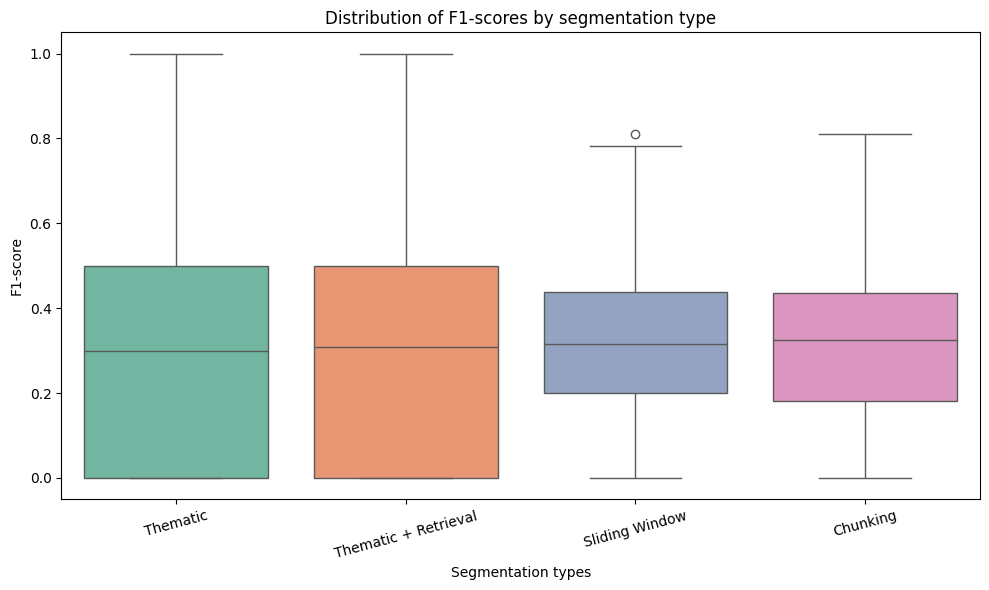

In [18]:
from scipy.stats import ttest_ind, ttest_rel, wilcoxon, shapiro, levene
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Regroupement
f1_data = {
    "Thematic": thematic_metrics['f1_by_doc'],
    "Thematic + Retrieval": retriever_metrics['f1_by_doc'],
    "Sliding Window": sliding_metrics['f1_by_doc'],
    "Chunking": chunk_metrics['f1_by_doc'],
}

# Vérification normalité
print("=== Test de normalité (Shapiro-Wilk) ===")
for name, scores in f1_data.items():
    stat, p = shapiro(scores)
    print(f"{name}: p = {p:.5f} {'(normale)' if p > 0.05 else '(non normale)'}")

# Vérification des variances
print("\n=== Test de variance (Levene) ===")
comparisons = [
    ("Thematic", "Thematic + Retrieval"),
    ("Thematic", "Sliding Window"),
    ("Thematic", "Chunking"),
    ("Thematic + Retrieval", "Sliding Window"),
    ("Thematic + Retrieval", "Chunking"),
]

for name1, name2 in comparisons:
    stat, p = levene(f1_data[name1], f1_data[name2])
    print(f"{name1} vs {name2}: p = {p:.5f} {'(variances égales)' if p > 0.05 else '(variances inégales)'}")

# Application du test statistique approprié
print("\n=== Tests statistiques (t-test ou Wilcoxon) ===")
for name1, name2 in comparisons:
    data1, data2 = f1_data[name1], f1_data[name2]
    p_norm1 = shapiro(data1).pvalue > 0.05
    p_norm2 = shapiro(data2).pvalue > 0.05
    paired = False  # sauf sliding vs chunking

    if name1 == "Sliding Window" and name2 == "Chunking":
        paired = True
        if p_norm1 and p_norm2:
            stat, p = ttest_rel(data1, data2)
            test_name = "t-test pairé"
        else:
            stat, p = wilcoxon(data1, data2)
            test_name = "Wilcoxon"
    else:
        if p_norm1 and p_norm2:
            stat, p = ttest_ind(data1, data2, equal_var=False)
            test_name = "t-test non pairé"
        else:
            from scipy.stats import mannwhitneyu
            stat, p = mannwhitneyu(data1, data2, alternative='two-sided')
            test_name = "Mann-Whitney"

    print(f"{name1} vs {name2}: {test_name} → p = {p:.5f}")

# Boxplot
all_data = []
for strategy, scores in f1_data.items():
    for score in scores:
        all_data.append({"Segmentation types": strategy, "F1-score": score})
df_plot = pd.DataFrame(all_data)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_plot, x="Segmentation types", y="F1-score", palette="Set2")
plt.title("Distribution of F1-scores by segmentation type")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
